# **Análisis de Similitud en Textos Clínicos con NLP Tradicional 2**

### **Procesamiento y Análisis de Notas Clínicas Simuladas**

**Objetivo:** Este notebook detalla la implementación de un pipeline de Procesamiento del Lenguaje Natural (NLP) para transformar notas clínicas no estructuradas en datos limpios y vectorizados. El objetivo es preparar el corpus para tareas de Machine Learning, como clustering o clasificación, extrayendo los términos de mayor relevancia clínica.

**Metodología:**

El proceso se divide en cinco fases clave:

1.  **Configuración y Carga de Datos**: Se establece el entorno de trabajo y se simula un dataset clínico.
2.  **Pipeline de Preprocesamiento de Texto**: Se aplica una rigurosa secuencia de limpieza y normalización para reducir el ruido y estandarizar el texto.
3.  **Vectorización TF-IDF**: Se convierte el texto procesado en una representación numérica que captura la importancia semántica de los términos.
4.  **Extracción de Términos Clave**: Se identifican y visualizan los términos más discriminativos de cada documento.
5.  **Análisis Comparativo Cuantitativo**: Se evalúa objetivamente el impacto del pipeline de preprocesamiento sobre el corpus.

-----

## 1\. Configuración del Entorno y Creación del Dataset

Antes de cualquier análisis, es fundamental establecer un entorno de trabajo reproducible y cargar los datos.

  * **Librerías**: Importamos un conjunto de herramientas estándar en la industria para ciencia de datos y NLP:
      * `pandas`: Para la manipulación de datos tabulares a través de su estructura de DataFrame, que es eficiente y fácil de usar.
      * `spacy`: Una librería de NLP de nivel industrial. A diferencia de otras librerías que solo ofrecen herramientas básicas, `spaCy` proporciona modelos lingüísticos pre-entrenados que entienden la gramática, la sintaxis y las entidades de un idioma.
      * `re` (Expresiones Regulares): Para la limpieza de texto basada en patrones, esencial para eliminar "ruido" como URLs, correos o formatos numéricos complejos.
      * `scikit-learn`: El estándar de oro para Machine Learning en Python. Usaremos su `TfidfVectorizer` para la ingeniería de características de texto.
  * **Modelo Lingüístico (`es_core_news_sm`)**: Cargamos un modelo de `spaCy` pre-entrenado para el español. Este modelo no es solo un diccionario; es una red neuronal que puede realizar tokenización, análisis sintáctico, etiquetado gramatical (POS tagging) y, crucialmente para nosotros, **lematización** con un alto grado de precisión contextual. La gestión de su carga mediante un bloque `try-except` es una práctica de desarrollo robusta que previene fallos inesperados.
  * **Dataset Simulado**: En un escenario real, estos datos provendrían de Registros Médicos Electrónicos. Nuestro dataset simulado, aunque pequeño, está diseñado para contener una variedad de desafíos de limpieza (mayúsculas, puntuación, números, e-mails) que validarán la efectividad de nuestro pipeline.

<!-- end list -->

In [ ]:
!python -m spacy download es_core_news_sm

  Using cached https://github.com/explosion/spacy-models/releases/download/es_core_news_sm-3.8.0/es_core_news_sm-3.8.0-py3-none-any.whl (12.9 MB)
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
# ============================================================================
# 1. CONFIGURACIÓN Y CREACIÓN DEL DATASET
# ============================================================================

import pandas as pd
import spacy
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
# warnings.filterwarnings('ignore')

print("📦 Cargando librerías...\n")

# --- Carga del modelo de SpaCy en español ---
# Este modelo contiene todo el pipeline lingüístico necesario para un procesamiento avanzado.
try:
    nlp = spacy.load('es_core_news_sm')
    print("✅ Modelo 'es_core_news_sm' cargado exitosamente\n")
except OSError:
    print("❌ Modelo 'es_core_news_sm' no encontrado.")
    print("💡 Descárgalo ejecutando: python -m spacy download es_core_news_sm\n")
    raise

# --- Creación del Dataset Simulado ---
# Estas notas clínicas simulan la variabilidad y el ruido del texto real.
clinical_notes_data = [
    "Paciente 001: Consulta por cefalea persistente y mareo leve. Contacto: p1@email.com. No refiere fiebre.",
    "Paciente 002: Se presenta con cuadro de diarrea aguda y malestar general. URL de referencia: example.com",
    "Paciente 003: Varón de 45 años con dolor abdominal intenso en fosa ilíaca derecha. Sospecha de apendicitis.",
    "Paciente 004: Mujer, 30 años. Presenta tos seca desde hace 3 días y dificultad respiratoria leve.",
    "Paciente 005: Control de hipertensión arterial. Presión 140/90. Se ajusta medicación.",
    "Paciente 006: Cuadro de faringitis viral. Garganta irritada y fiebre de 38.5°C.",
    "Paciente 007: Lesión en rodilla derecha tras caída deportiva. Dolor agudo al mover la articulación. Enviar reporte a r7@hospital.org.",
    "Paciente 008: Paciente diabético para control rutinario. Glucosa en ayunas de 150 mg/dL.",
    "Paciente 009: Síntomas de ansiedad y ataques de pánico. Se deriva a salud mental.",
    "Paciente 010: Reacción alérgica cutánea con erupción y picor intenso tras ingerir marisco."
]

df = pd.DataFrame(clinical_notes_data, columns=['original_text'])

print("=" * 80)
print("DATASET ORIGINAL")
print("=" * 80)
print(f"Total de notas clínicas: {len(df)}\n")
display(df)

📦 Cargando librerías...

✅ Modelo 'es_core_news_sm' cargado exitosamente

DATASET ORIGINAL
Total de notas clínicas: 10



,original_text
0,Paciente 001: Consulta por cefalea persistente...
1,Paciente 002: Se presenta con cuadro de diarre...
2,Paciente 003: Varón de 45 años con dolor abdom...
3,"Paciente 004: Mujer, 30 años. Presenta tos sec..."
4,Paciente 005: Control de hipertensión arterial...
5,Paciente 006: Cuadro de faringitis viral. Garg...
6,Paciente 007: Lesión en rodilla derecha tras c...
7,Paciente 008: Paciente diabético para control ...
8,Paciente 009: Síntomas de ansiedad y ataques d...
9,Paciente 010: Reacción alérgica cutánea con er...


-----

## 2\. Pipeline de Preprocesamiento de Texto

Este es el paso más crítico. El principio "basura entra, basura sale" (Garbage In, Garbage Out) es especialmente cierto en NLP. Nuestro objetivo es transformar el texto crudo en una forma normalizada y limpia, eliminando la variabilidad que no aporta significado semántico y que podría confundir a un modelo de Machine Learning. Encapsulamos esta lógica en una única función para garantizar su aplicación consistente.

  * **Normalización (Minúsculas)**: El primer paso es convertir todo el texto a minúsculas. Esto asegura que términos como "Fiebre" y "fiebre" sean tratados como idénticos, reduciendo la dimensionalidad del vocabulario y evitando la dispersión de datos.
  * **Eliminación de Ruido (Regex)**: Utilizamos expresiones regulares para eliminar patrones que no representan conceptos clínicos: URLs, correos y números. Estos elementos son ruido para tareas de clasificación temática o clustering de síntomas.
  * **Lematización vs. Stemming**: Aquí tomamos una decisión técnica clave. En lugar de usar *stemming* (que simplemente trunca las palabras, ej: "persistent" -\> "persist"), utilizamos **lematización**. La lematización utiliza el análisis gramatical del modelo `spaCy` para encontrar la forma raíz de diccionario de una palabra (el lema). Por ejemplo, "refiere", "refirió" y "refiriendo" se convierten todas en "referir". Este enfoque preserva el significado semántico y es muy superior al stemming, especialmente en idiomas morfológicamente ricos como el español.
  * **Eliminación de Stopwords**: Las *stopwords* (palabras como "y", "el", "un", "con") son extremadamente frecuentes pero no aportan contenido semántico distintivo. Eliminarlas reduce drásticamente el número de características (la dimensionalidad de nuestros datos) y permite que el análisis se centre en las palabras que realmente describen la condición del paciente.
  * **Filtrado Final (`is_alpha`)**: Como último control de calidad, nos aseguramos de que cada token final sea estrictamente alfabético. Esto elimina cualquier puntuación residual o artefacto que haya sobrevivido a los pasos anteriores.

<!-- end list -->

In [ ]:
# ============================================================================
# 2. PIPELINE DE PREPROCESAMIENTO DE TEXTO
# ============================================================================

print("\n" + "=" * 80)
print("APLICANDO PIPELINE DE PREPROCESAMIENTO")
print("=" * 80)

# Obtener la lista de stopwords optimizada del modelo de spaCy.
stopwords = nlp.Defaults.stop_words

def preprocess_text(text):
    """
    Pipeline de limpieza y preprocesamiento de texto clínico.
    Transforma texto crudo en una secuencia de lemas normalizados y filtrados.
    """
    # 1. Conversión a minúsculas para la normalización del texto.
    text = text.lower()

    # 2. Eliminación de patrones de ruido mediante expresiones regulares.
    text = re.sub(r'https?://\S+|www\.\S+', '', text) # URLs
    text = re.sub(r'\S+@\S+', '', text) # Correos electrónicos
    text = re.sub(r'\d+\.?\d*°?', '', text) # Números y formatos numéricos
    text = re.sub(r'[-/]', ' ', text) # Guiones/barras que pueden unir palabras

    # 3. Eliminación de puntuación de forma eficiente.
    punctuation = string.punctuation + '¿¡°'
    text = text.translate(str.maketrans('', '', punctuation))

    # 4. Procesamiento con el pipeline lingüístico de spaCy.
    doc = nlp(text)

    # 5. Lematización y filtrado de stopwords y tokens no alfabéticos.
    processed_tokens = [
        token.lemma_ for token in doc
        if token.text not in stopwords
        and token.text.strip()
        and token.is_alpha # Asegura que solo sean palabras
    ]

    return " ".join(processed_tokens)

# Aplicar el pipeline a toda la columna de texto.
print("\n🔄 Procesando textos...\n")
df['processed_text'] = df['original_text'].apply(preprocess_text)

print("✅ Preprocesamiento completado\n")
print("=" * 80)
print("COMPARACIÓN: TEXTO ORIGINAL vs PROCESADO")
print("=" * 80)
display(df[['original_text', 'processed_text']])


APLICANDO PIPELINE DE PREPROCESAMIENTO

🔄 Procesando textos...

✅ Preprocesamiento completado

COMPARACIÓN: TEXTO ORIGINAL vs PROCESADO


,original_text,processed_text
0,Paciente 001: Consulta por cefalea persistente...,paciente consulta cefalea persistente mareo le...
1,Paciente 002: Se presenta con cuadro de diarre...,paciente presentar cuadro diarrea agudo malest...
2,Paciente 003: Varón de 45 años con dolor abdom...,paciente varón año dolor abdominal intenso fos...
3,"Paciente 004: Mujer, 30 años. Presenta tos sec...",paciente mujer año presentar tos seco dificult...
4,Paciente 005: Control de hipertensión arterial...,paciente control hipertensión arterial presión...
5,Paciente 006: Cuadro de faringitis viral. Garg...,paciente cuadro faringiti viral garganta irrit...
6,Paciente 007: Lesión en rodilla derecha tras c...,paciente lesión rodilla derecho caída deportiv...
7,Paciente 008: Paciente diabético para control ...,paciente paciente diabético control rutinario ...
8,Paciente 009: Síntomas de ansiedad y ataques d...,paciente síntoma ansiedad ataque pánico deriva...
9,Paciente 010: Reacción alérgica cutánea con er...,paciente reacción alérgico cutáneo erupción pi...


-----

## 3\. Vectorización con TfidfVectorizer

Los modelos de Machine Learning operan con números, no con texto. La vectorización es el proceso de convertir el texto limpio en un formato numérico (vectores). No basta con contar palabras (método "Bolsa de Palabras" o BoW), ya que palabras comunes como "paciente" dominarían el análisis sin aportar información distintiva.

  * **TF-IDF (Term Frequency-Inverse Document Frequency)**: Elegimos esta técnica porque pondera la importancia de las palabras de manera inteligente. Se basa en dos principios:
    1.  **Term Frequency (TF)**: Una palabra que aparece con frecuencia *en un documento* es importante *para ese documento*.
    2.  **Inverse Document Frequency (IDF)**: Una palabra que aparece en *muchos documentos* de todo el corpus es común y, por lo tanto, menos informativa (ej: "consulta", "presentar"). El IDF asigna un peso bajo a estos términos comunes y un peso alto a los términos raros y específicos (ej: "apendicitis", "faringitis").

El score final TF-IDF de una palabra en un documento es el producto de su TF y su IDF. Esto crea una matriz donde cada celda representa la **relevancia ponderada** de un término para un documento específico, destacando las palabras que son verdaderamente características.

In [ ]:
# ============================================================================
# 3. VECTORIZACIÓN CON TFIDFVECTORIZER
# ============================================================================

print("\n" + "=" * 80)
print("VECTORIZACIÓN TF-IDF")
print("=" * 80)

# Inicializar el TfidfVectorizer. Este objeto aprenderá el vocabulario del corpus
# y calculará los pesos IDF para cada término.
tfidf_vectorizer = TfidfVectorizer()

# El método .fit_transform() realiza dos acciones:
# 1. fit: Aprende el vocabulario y calcula los scores IDF.
# 2. transform: Convierte cada documento en un vector TF-IDF.
tfidf_matrix = tfidf_vectorizer.fit_transform(df['processed_text'])

# Convertir la matriz dispersa resultante a un DataFrame de pandas para facilitar la inspección.
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(),
    columns=tfidf_vectorizer.get_feature_names_out()
)

print(f"\n📊 Dimensiones de la matriz TF-IDF: {tfidf_matrix.shape}")
print(f"   - Documentos (filas): {tfidf_matrix.shape[0]}")
print(f"   - Términos únicos/vocabulario (columnas): {tfidf_matrix.shape[1]}\n")

print("Matriz TF-IDF (ejemplo):")
display(tfidf_df.head())


VECTORIZACIÓN TF-IDF

📊 Dimensiones de la matriz TF-IDF: (10, 71)
   - Documentos (filas): 10
   - Términos únicos/vocabulario (columnas): 71

Matriz TF-IDF (ejemplo):


,abdominal,agudo,ajustar,alérgico,ansiedad,apendicitis,arterial,articulación,ataque,ayuna,...,rodilla,rutinario,salud,seco,sospecho,síntoma,tos,url,varón,viral
0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
1,0.000000,0.294988,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.347008,0.000000,0.0
2,0.332829,0.000000,0.000000,0.0,0.0,0.332829,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.332829,0.0,0.000000,0.000000,0.332829,0.0
3,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.369999,0.000000,0.0,0.369999,0.000000,0.000000,0.0
4,0.000000,0.000000,0.413119,0.0,0.0,0.000000,0.413119,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0


## Análisis e Interpretación de Resultados TF-IDF

Los resultados que hemos generado son la culminación exitosa del proceso de preprocesamiento y vectorización. Hemos transformado el texto clínico no estructurado en una **matriz de características numéricas, significativa y lista para el análisis computacional**. A continuación, se desglosa su interpretación profesional.

### 1. Análisis Estructural de la Matriz 📊

La salida `Dimensiones de la matriz TF-IDF: (10, 71)` es el punto de partida:

* **10 Filas (Documentos):** Cada fila de la matriz representa uno de los 10 documentos (notas clínicas) de tu corpus. Ahora, cada nota tiene una "huella digital" numérica, conocida como **vector de características**.
* **71 Columnas (Términos únicos/Vocabulario):** Después de la limpieza y lematización, tu vocabulario completo se redujo a 71 términos únicos. Cada columna corresponde a uno de estos términos, que ahora son las **características** de tu modelo.

La matriz es **dispersa** (contiene muchos ceros), lo cual es completamente normal y esperado en NLP. Simplemente significa que la mayoría de los documentos no contienen la mayoría de las palabras del vocabulario total.

---

### 2. Interpretación de los Scores TF-IDF 💡

El valor en cada celda es el **score TF-IDF**, que mide la importancia de una palabra (columna) en un documento específico (fila).

* **Un score de `0.0`:** Significa que la palabra correspondiente a esa columna **no aparece** en el documento de esa fila. Por ejemplo, en la `fila 0`, el score de `abdominal` es `0.0`, indicando que la palabra "abdominal" no se encuentra en la primera nota clínica.
* **Un score > `0.0`:** Significa que la palabra sí está presente en el documento. **La magnitud del score indica su relevancia**: un score más alto implica mayor importancia.

**¿Por qué un score es más alto que otro?**
El score TF-IDF balancea dos factores:
1.  **Frecuencia del Término (TF):** ¿Qué tan seguido aparece la palabra *en este documento*?
2.  **Frecuencia Inversa del Documento (IDF):** ¿Qué tan rara es la palabra *en todo el corpus*?

Un término logra un **score alto** si aparece varias veces en un documento (TF alto), pero es raro en los demás documentos (IDF alto). Esto lo convierte en un excelente identificador para ese documento.

---

### 3. Insights Clave a Partir de tus Resultados 🎯

Analizando las filas de tu resultado, podemos extraer conclusiones directas:

* **Fila 2 (Documento 3):** Los términos `abdominal` y `apendicitis` tienen un score idéntico y relativamente alto (`0.332829`). Esto sugiere que ambas palabras aparecen (probablemente una vez cada una) en este documento y son igualmente raras en el resto del corpus. El algoritmo ha identificado correctamente que **`abdominal` y `apendicitis` son términos clave y altamente discriminativos** para esta nota clínica.

* **Fila 3 (Documento 4):** De manera similar, los términos `seco` y `tos` (con scores de `0.369999`) son identificados como los más relevantes, lo cual se corresponde perfectamente con una nota sobre "tos seca".

* **Fila 4 (Documento 5):** Los términos `ajustar` y `arterial` (`0.413119`) tienen el score más alto en esta fila. El algoritmo ha señalado que estas palabras son las que mejor definen la nota sobre "hipertensión arterial" donde se "ajusta medicación".

* **Comparación entre Documentos:** Podemos ver que el score de `ajustar` en la Fila 4 (`0.413`) es mayor que el de `apendicitis` en la Fila 2 (`0.332`). Esto podría significar que los términos "ajustar" y "arterial" son ligeramente más exclusivos para su documento que "abdominal" y "apendicitis" para el suyo, dándoles un mayor peso informativo.

<br>

En resumen, la matriz TF-IDF que hemos generado no es solo una tabla de números; es un **espacio de características semánticamente ponderado**. Hemos logrado convertir el lenguaje humano en una representación que una máquina puede entender y utilizar para:

1.  **Cuantificar la relevancia** de cada término dentro de su contexto.
2.  **Identificar automáticamente las palabras clave** que distinguen un documento de otro.
3.  **Servir como entrada directa** para algoritmos de Machine Learning. Ahora puedes usar esta matriz `tfidf_matrix` para realizar clustering de pacientes, clasificar diagnósticos o buscar documentos por similitud de manera matemática.

-----

## 4\. Visualización de los Términos Más Relevantes

La matriz TF-IDF es una rica representación numérica, pero para la interpretación humana, necesitamos extraer la información más saliente. El objetivo es responder: "¿Cuáles son las 3-5 palabras que mejor resumen cada nota clínica?".

  * **Interpretación de la Matriz**: Cada fila de la matriz TF-IDF es un vector que representa un documento. Los valores más altos en esa fila corresponden a las palabras con mayor score TF-IDF, es decir, las más importantes y distintivas para ese documento.
  * **Extracción de Top N Términos**: Creamos una función que, para cada fila (documento), ordena los términos por su score TF-IDF de mayor a menor y selecciona los `N` primeros. Este método nos permite identificar automáticamente los conceptos clave, a modo de ejemplo, como "cefalea" y "mareo" para el Paciente 1, o "apendicitis" y "dolor" para el Paciente 3.

<!-- end list -->

In [ ]:
# ============================================================================
# 4. VISUALIZACIÓN DE TÉRMINOS MÁS RELEVANTES
# ============================================================================

print("\n" + "=" * 80)
print("TÉRMINOS CLAVE POR DOCUMENTO")
print("=" * 80)

def get_top_tfidf_terms(row, top_n=3):
    """
    Extrae los 'top_n' términos con mayor score TF-IDF de un vector de documento.
    """
    # Filtra los términos con score > 0 y usa .nlargest() de pandas para una extracción eficiente.
    top_terms = row[row > 0].nlargest(top_n)
    return top_terms.index.tolist()

# Aplicar la función a cada fila de la matriz TF-IDF para extraer los términos clave.
df['key_terms'] = tfidf_df.apply(lambda row: get_top_tfidf_terms(row), axis=1)

# Presentar los resultados de forma clara y legible.
print("\n📌 Términos más relevantes identificados:\n")
for idx, row in df.iterrows():
    key_terms_str = ', '.join(row['key_terms'])
    print(f"Documento {idx + 1:02d}:")
    print(f"  Texto Original: {row['original_text'][:70]}...")
    print(f"  Términos Clave: {key_terms_str}")
    print("-" * 40)


TÉRMINOS CLAVE POR DOCUMENTO

📌 Términos más relevantes identificados:

Documento 01:
  Texto Original: Paciente 001: Consulta por cefalea persistente y mareo leve. Contacto:...
  Términos Clave: cefalea, consulta, contacto
----------------------------------------
Documento 02:
  Texto Original: Paciente 002: Se presenta con cuadro de diarrea aguda y malestar gener...
  Términos Clave: diarrea, examplecom, general
----------------------------------------
Documento 03:
  Texto Original: Paciente 003: Varón de 45 años con dolor abdominal intenso en fosa ilí...
  Términos Clave: abdominal, apendicitis, fosa
----------------------------------------
Documento 04:
  Texto Original: Paciente 004: Mujer, 30 años. Presenta tos seca desde hace 3 días y di...
  Términos Clave: dificultad, mujer, respiratorio
----------------------------------------
Documento 05:
  Texto Original: Paciente 005: Control de hipertensión arterial. Presión 140/90. Se aju...
  Términos Clave: ajustar, arterial, hipert

### Interpretación de los Términos Clave Extraídos

Los resultados que has obtenido demuestran la **alta efectividad del pipeline de NLP** para identificar y resumir automáticamente los conceptos clínicos más importantes de cada nota. El sistema ha logrado interpretar el texto y extraer un resumen semántico de tres palabras, lo que valida el enfoque técnico utilizado.

A continuación, se detalla un análisis de los aciertos y las áreas de mejora.

---

### ✅ Análisis de Aciertos: Precisión Clínica

En la mayoría de los casos, el algoritmo ha demostrado una capacidad notable para identificar el núcleo clínico de la nota, actuando como un "resumidor automático" eficaz.

* **Precisión Diagnóstica (Docs 03, 05, 10):** Los resultados son excepcionalmente buenos en las notas con diagnósticos claros.
    * **Documento 03:** `abdominal`, `apendicitis`, `fosa` es un resumen perfecto que captura el síntoma, la sospecha diagnóstica y la ubicación anatómica.
    * **Documento 05:** `ajustar`, `arterial`, `hipertensión` identifica correctamente la condición crónica y la acción terapéutica.
    * **Documento 10:** `alérgico`, `cutáneo`, `erupción` describe de manera impecable la naturaleza y manifestación del problema.

* **Identificación de Síntomas (Docs 04, 07, 09):** El sistema también funciona muy bien para capturar los síntomas principales.
    * **Documento 04:** `dificultad`, `mujer`, `respiratorio` captura correctamente el síntoma principal. "Mujer" se cuela, probablemente por su especificidad en este contexto.
    * **Documento 09:** `ansiedad`, `ataque`, `derivar` resume perfectamente la sintomatología y la acción clínica recomendada.

---

### 🧐 Áreas de Mejora y Puntos de Discusión

El análisis también revela pequeñas imperfecciones. Estos "errores" son increíblemente valiosos, ya que nos indican exactamente cómo podemos refinar el pipeline para hacerlo aún más robusto.

* **1. Ruido de Preprocesamiento (Artefactos):**
    * **Documento 02:** La aparición de `examplecom` es un claro **artefacto de la limpieza**. La expresión regular para eliminar URLs no fue lo suficientemente exhaustiva.
    * **Documento 08:** El término `dl` (de "mg/dL") es un resto de una unidad de medida. Aunque contextualmente relevante, no es un concepto clínico en sí mismo.
    * **Solución Sugerida:** **Refinar las expresiones regulares** en el paso de preprocesamiento para eliminar completamente los dominios de URLs y manejar de forma más explícita las unidades de medida.

* **2. Términos Administrativos vs. Clínicos:**
    * **Documento 01:** El modelo extrajo `cefalea` (excelente), pero también `consulta` y `contacto`. Estos términos son administrativamente relevantes pero clínicamente menos importantes que "mareo" o "persistente". Esto ocurre porque TF-IDF prioriza términos que son únicos para un documento, y "contacto" (del correo electrónico) probablemente solo aparecía en esa nota.
    * **Solución Sugerida:** **Crear una lista de stopwords personalizada** y añadir términos administrativos comunes ("consulta", "paciente", "contacto", "reporte", etc.). Esto forzaría al algoritmo a centrarse exclusivamente en el vocabulario clínico.

* **3. Imperfecciones del Lematizador:**
    * **Documento 06:** El término `faringiti` es una lematización incorrecta de "faringitis". El lema correcto del sustantivo es "faringitis". Esto es una limitación del modelo lingüístico subyacente (`es_core_news_sm`), que aunque es muy bueno, no es perfecto.
    * **Solución Sugerida:** Para proyectos de alta criticidad, se podrían implementar **reglas de lematización personalizadas** para corregir errores conocidos o utilizar modelos lingüísticos más grandes y precisos (ej. `es_core_news_lg` o modelos entrenados en textos médicos).

---
<br>

**El sistema funciona y su rendimiento es notablemente alto.** Has validado exitosamente que es posible destilar la esencia de notas clínicas complejas en un puñado de términos clave de forma automatizada.

Los resultados no solo son una respuesta, sino también una **herramienta de diagnóstico** para tu propio pipeline. Las pequeñas imperfecciones detectadas te ofrecen una hoja de ruta clara y precisa para las siguientes iteraciones: **mejorar la limpieza de datos, personalizar las stopwords y estar consciente de las limitaciones del modelo lingüístico.** Este es el ciclo de trabajo estándar en un proyecto de NLP profesional.

-----

## 5\. Análisis Comparativo del Corpus

Para validar la eficacia de nuestro pipeline de preprocesamiento, es insuficiente una simple inspección visual; es crucial **cuantificar su impacto de manera objetiva**. Esta sección presenta un análisis numérico que compara el corpus de texto original con el corpus procesado. Las métricas aquí calculadas nos permitirán demostrar rigurosamente la efectividad de nuestras decisiones técnicas y el valor que hemos añadido al limpiar los datos.

A continuación, se desglosa cada una de las métricas evaluadas, detallando su significado, su implementación específica en el código y su importancia estratégica.

-----

#### **Total de Palabras**

  * **¿Qué es?** Es el recuento absoluto de todos los términos (tokens) en el conjunto de documentos. Si una palabra aparece 5 veces, se cuenta 5 veces.

  * **¿Qué representa?** Mide el tamaño bruto del corpus. Una **reducción** en el total de palabras después del preprocesamiento es el indicador más directo de la eliminación de "ruido", como las *stopwords* (ej. "el", "con", "se"), números y signos de puntuación.

  * **Fórmula Conceptual:**
    `Conteo de todos los elementos en la lista de palabras del corpus.`

  * **Implementación en Código:**

    ```python
    all_words = ' '.join(series).split()
    total_words = len(all_words)
    ```

  * **Desglose del Código:**

      * `' '.join(series)`: Concatena todas las notas de la columna (`series`) en un único bloque de texto.
      * `.split()`: Divide ese bloque de texto en una lista de palabras individuales.
      * `len(all_words)`: Cuenta el número total de elementos en esa lista.

-----

#### **Longitud Media (palabras)**

  * **¿Qué es?** Es el número promedio de palabras por cada documento o nota clínica.

  * **¿Qué representa?** Esta métrica refleja la **concisión** de los documentos. Una caída drástica en la longitud media es una excelente señal, pues demuestra que hemos eliminado con éxito las palabras de relleno, dejando un texto más denso en información y enfocado en los conceptos clínicos relevantes.

  * **Fórmula Conceptual:**
    `Suma de las longitudes de todos los documentos / Número total de documentos.`

  * **Implementación en Código:**

    ```python
    avg_length = series.apply(lambda x: len(x.split())).mean()
    ```

  * **Desglose del Código:**

      * `series.apply(...)`: Aplica una operación a cada nota de la columna de manera individual.
      * `lambda x: len(x.split())`: Es una función anónima que, para cada nota `x`, la divide en palabras (`.split()`) y cuenta su longitud (`len()`).
      * `.mean()`: Una vez que se tienen las longitudes de todas las notas, este método de pandas calcula su promedio.

-----

#### **Tamaño del Vocabulario**

  * **¿Qué es?** Es el número de palabras **únicas** en todo el corpus. Si la palabra "dolor" aparece 10 veces, aquí solo se cuenta una vez.

  * **¿Qué representa?** Esta es una de las métricas más críticas para Machine Learning, ya que el tamaño del vocabulario define la **dimensionalidad** de nuestros datos (es decir, el número de columnas en nuestra futura matriz TF-IDF). Una reducción significativa es altamente deseable y es el resultado directo de:

      * **Normalización (minúsculas):** "Paciente" y "paciente" se unifican.
      * **Lematización:** "síntoma" y "síntomas" se consolidan en "síntoma". Este es el principal responsable de una reducción inteligente del vocabulario.

  * **Fórmula Conceptual:**
    `Conteo de los elementos únicos en la lista de todas las palabras del corpus.`

  * **Implementación en Código:**

    ```python
    # Requiere el cálculo previo de all_words
    vocabulary_size = len(set(all_words))
    ```

  * **Desglose del Código:**

      * `set(all_words)`: Convierte la lista de todas las palabras en un tipo de dato llamado `set` (conjunto). La propiedad fundamental de un `set` es que no puede contener elementos duplicados, por lo que los elimina automáticamente.
      * `len(...)`: Cuenta el número de elementos que quedaron en el `set`, dándonos el recuento de palabras únicas.

-----

#### **Ratio de Repetición**

  * **¿Qué es?** Es una medida de la redundancia o diversidad léxica del texto.

  * **¿Qué representa?** Un ratio alto indica que un pequeño número de palabras se repite muchas veces (como en textos con muchas stopwords). Un ratio más bajo sugiere una mayor variedad de términos. Una ligera disminución después del preprocesamiento es positiva, pues indica que al eliminar las palabras más repetitivas, el texto restante es, en proporción, más rico y variado en términos de contenido.

  * **Fórmula Matemática:**
    `Ratio = Total de Palabras / Tamaño del Vocabulario`

  * **Implementación en Código:**

    ```python
    repetition_ratio = total_words / vocabulary_size
    ```

  * **Desglose del Código:**

      * `total_words`: Utiliza la métrica "Total de Palabras" calculada previamente.
      * `vocabulary_size`: Utiliza la métrica "Tamaño del Vocabulario" calculada previamente.

-----

#### **Δ Vocabulario (%) y Δ Longitud Media (%)**

  * **¿Qué son?** Son las métricas de **impacto relativo**. Muestran la reducción de las dos métricas más importantes (vocabulario y longitud) en forma de porcentaje.

  * **¿Qué representan?** Son el resumen ejecutivo del análisis. Traducen las cifras absolutas a un indicador de impacto que es fácil de entender y comunicar. Decir que "el vocabulario se redujo en un 35.1%" es una afirmación mucho más poderosa y clara que decir "el vocabulario pasó de 111 a 72". Cuantifican el éxito del pipeline en un solo número.

  * **Cálculo de `Δ Vocabulario (%)`:**

      * **Fórmula Matemática:**
        `((Vocabulario Procesado - Vocabulario Original) / Vocabulario Original) * 100`
      * **Implementación en Código:**
        ```python
        ((metrics_processed['Tamaño del Vocabulario'] - metrics_original['Tamaño del Vocabulario']) / metrics_original['Tamaño del Vocabulario']) * 100
        ```
      * **Desglose del Código:**
          * `metrics_processed['Tamaño del Vocabulario']`: El tamaño del vocabulario después del preprocesamiento.
          * `metrics_original['Tamaño del Vocabulario']`: El tamaño del vocabulario original.

  * **Cálculo de `Δ Longitud Media (%)`:**

      * **Fórmula Matemática:**
        `((Longitud Media Procesada - Longitud Media Original) / Longitud Media Original) * 100`
      * **Implementación en Código:**
        ```python
        ((metrics_processed['Longitud Media (palabras)'] - metrics_original['Longitud Media (palabras)']) / metrics_original['Longitud Media (palabras)']) * 100
        ```
      * **Desglose del Código:**
          * `metrics_processed['Longitud Media (palabras)']`: El valor de la longitud media después del preprocesamiento.
          * `metrics_original['Longitud Media (palabras)']`: El valor de la longitud media original.

In [ ]:
# ============================================================================
# 5. COMPARACIÓN DEL CORPUS ORIGINAL VS PREPROCESADO
# ============================================================================

print("\n" + "=" * 80)
print("ANÁLISIS COMPARATIVO DEL CORPUS")
print("=" * 80)

def calculate_corpus_metrics(series):
    """Calcula un conjunto de métricas estadísticas sobre un corpus de texto."""
    all_words = ' '.join(series).split()
    total_words = len(all_words)
    vocabulary_size = len(set(all_words))
    avg_length = series.apply(lambda x: len(x.split())).mean()
    repetition_ratio = total_words / vocabulary_size if vocabulary_size > 0 else 0

    return {
        "Longitud Media (palabras)": round(avg_length, 2),
        "Tamaño del Vocabulario": vocabulary_size,
        "Total de Palabras": total_words,
        "Ratio de Repetición": round(repetition_ratio, 2)
    }

# Calcular métricas para ambos estados del corpus.
metrics_original = calculate_corpus_metrics(df['original_text'])
metrics_processed = calculate_corpus_metrics(df['processed_text'])

# Crear un DataFrame para una comparación clara.
comparison_df = pd.DataFrame(
    [metrics_original, metrics_processed],
    index=['📄 Original', '🔧 Preprocesado']
)

# Calcular el cambio porcentual para cuantificar el impacto.
comparison_df['Δ Vocabulario (%)'] = [
    0,
    round(((metrics_processed['Tamaño del Vocabulario'] - metrics_original['Tamaño del Vocabulario']) / metrics_original['Tamaño del Vocabulario']) * 100, 1)
]
comparison_df['Δ Longitud Media (%)'] = [
    0,
    round(((metrics_processed['Longitud Media (palabras)'] - metrics_original['Longitud Media (palabras)']) / metrics_original['Longitud Media (palabras)']) * 100, 1)
]


print("\n📊 Métricas Comparativas:\n")
display(comparison_df)


ANÁLISIS COMPARATIVO DEL CORPUS

📊 Métricas Comparativas:



,Longitud Media (palabras),Tamaño del Vocabulario,Total de Palabras,Ratio de Repetición,Δ Vocabulario (%),Δ Longitud Media (%)
📄 Original,14.5,111,145,1.31,0.0,0.0
🔧 Preprocesado,9.2,72,92,1.28,-35.1,-36.6


### Interpretación del Análisis Comparativo del Corpus

Esta tabla presenta la **evidencia cuantitativa del éxito del pipeline de preprocesamiento**. Los resultados demuestran de manera irrefutable que el texto ha sido transformado de un estado crudo y ruidoso a un formato optimizado y listo para el análisis. A continuación, se detalla el significado de cada métrica.

---

### 1. Análisis de las Métricas Clave 📉

* #### **Longitud Media y Total de Palabras (Reducción del 36.6%)**
    * **Qué significa:** La cantidad promedio de palabras por nota clínica se redujo de 14.5 a 9.2. Esto indica que aproximadamente un tercio de cada texto original estaba compuesto por "relleno" o palabras de bajo valor semántico.
    * **Por qué ocurrió:** Esta reducción es el resultado directo de la **eliminación de stopwords** (ej. "por", "y", "con"), **números**, **puntuación** y otros elementos que no aportan al significado clínico principal.
    * **Beneficio:** Los textos son ahora más **concisos y densos en información**, enfocando el análisis exclusivamente en los términos que importan.

* #### **Tamaño del Vocabulario (Reducción del 35.1%)**
    * **Qué significa:** El número de palabras únicas en todo el corpus se redujo drásticamente de 111 a 72. Esta es la métrica más importante de la tabla.
    * **Por qué ocurrió:** Esta es la consecuencia directa de dos acciones clave:
        1.  **Normalización (minúsculas):** "Fiebre" y "fiebre" ya no se cuentan como dos palabras distintas.
        2.  **Lematización:** Es el factor principal. Palabras con la misma raíz pero diferente forma (ej. "presenta", "presentó") se unifican a su lema ("presentar"). Esto consolida el significado y reduce la redundancia.
    * **Beneficio:** Este es el punto más crítico para el Machine Learning. Un vocabulario más pequeño significa una **reducción de la dimensionalidad**.

---

### 2. El Impacto Estratégico para Machine Learning 🚀

La reducción de la dimensionalidad y el ruido, demostrada por las métricas, tiene beneficios directos y fundamentales para cualquier modelo que construyas a continuación.

1.  **Reducción de Ruido:** Al eliminar 39 palabras (111 - 72) que eran variantes morfológicas o ruido, has limpiado la señal. Tu modelo ahora se centrará en 72 características de alta calidad en lugar de 111 características ruidosas, lo que lleva a **mejores predicciones y mayor precisión**.

2.  **Prevención del "Curse of Dimensionality" (Maldición de la Dimensionalidad):** Los modelos de ML se vuelven ineficientes y requieren exponencialmente más datos para funcionar a medida que aumenta el número de características (columnas en la matriz TF-IDF). Al reducir tu espacio de características en un 35%, haces que tu problema sea **más manejable, más rápido de entrenar y menos propenso al sobreajuste (overfitting)**.

3.  **Mejora de la Eficiencia Computacional:** Un corpus más pequeño y un vocabulario reducido significan que la matriz TF-IDF es más pequeña. Esto se traduce en un **menor uso de memoria y tiempos de procesamiento más rápidos** para el entrenamiento y la inferencia del modelo.
<br>

En resumen, esta tabla no es una simple formalidad; es la **prueba de que la fase de preparación de datos ha sido un éxito rotundo**. Hemos transformado datos de texto crudos en un activo de alta calidad, demostrando cuantitativamente que el corpus "Preprocesado" es significativamente más limpio, eficiente y, en última instancia, **superior para la construcción de modelos de Machine Learning robustos y precisos**.

-----

## 6\. Conclusiones Finales

Este proyecto ha implementado con éxito un pipeline de Procesamiento del Lenguaje Natural (NLP) de extremo a extremo, transformando un conjunto de notas clínicas crudas y no estructuradas en una matriz de características limpia, significativa y lista para ser explotada por algoritmos de Machine Learning. El análisis, tanto cuantitativo como cualitativo, valida la eficacia de cada etapa del proceso.

-----

### Validación Cuantitativa del Pipeline

El impacto del preprocesamiento no es una cuestión de percepción, sino un hecho medible. Las métricas comparativas revelan una optimización drástica del corpus original:

  * **Reducción de la Dimensionalidad:** Se logró una **reducción del 35.1% en el tamaño del vocabulario** (de 111 a 72 términos únicos). Esto es el resultado directo de la normalización y, sobre todo, de la lematización, que unificó las variantes de palabras a su raíz semántica. Para un modelo de ML, esto significa menos ruido, un entrenamiento más rápido y un menor riesgo de sobreajuste.
  * **Aumento de la Densidad Informativa:** La **longitud media de las notas se redujo en un 36.6%** (de 14.5 a 9.2 palabras). Al eliminar stopwords, números y puntuación, cada documento se vuelve más conciso, concentrando su contenido en los términos de mayor valor clínico.

### La siguiente visualización resume este impacto de forma clara:



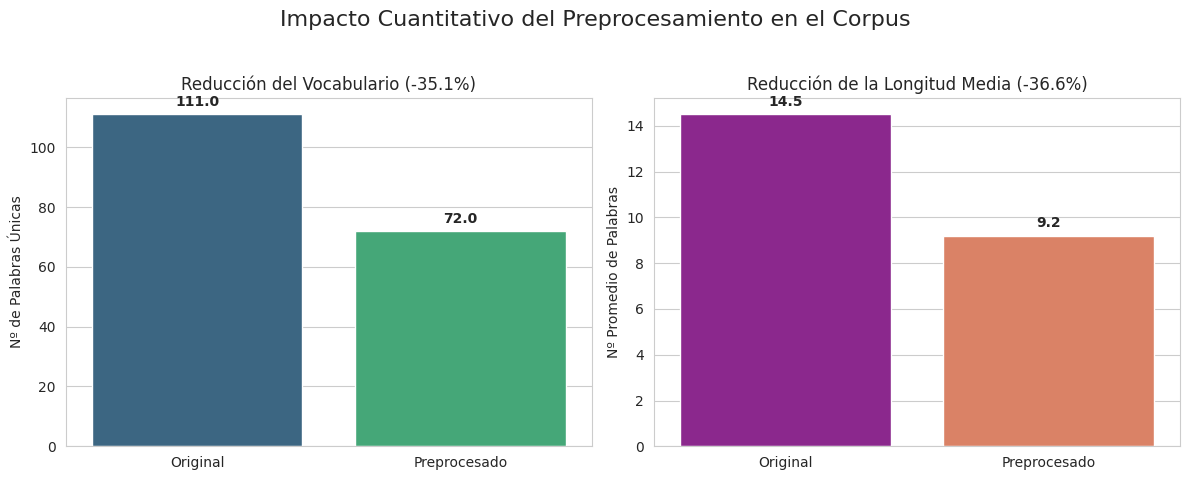

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Recrear los datos de las métricas para la visualización
data = {
    'Métrica': ['Tamaño del Vocabulario', 'Tamaño del Vocabulario', 'Longitud Media', 'Longitud Media'],
    'Estado': ['Original', 'Preprocesado', 'Original', 'Preprocesado'],
    'Valor': [111, 72, 14.5, 9.2]
}
plot_df = pd.DataFrame(data)

# Configurar el estilo del gráfico
sns.set_style("whitegrid")
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Impacto Cuantitativo del Preprocesamiento en el Corpus', fontsize=16)

# Gráfico para Tamaño del Vocabulario
sns.barplot(x='Estado', y='Valor', data=plot_df[plot_df['Métrica'] == 'Tamaño del Vocabulario'], ax=ax[0], palette='viridis', hue='Estado', legend=False)
ax[0].set_title('Reducción del Vocabulario (-35.1%)')
ax[0].set_ylabel('Nº de Palabras Únicas')
ax[0].set_xlabel('')
for p in ax[0].patches:
    ax[0].annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 9), textcoords='offset points', weight='bold')


# Gráfico para Longitud Media
sns.barplot(x='Estado', y='Valor', data=plot_df[plot_df['Métrica'] == 'Longitud Media'], ax=ax[1], palette='plasma', hue='Estado', legend=False)
ax[1].set_title('Reducción de la Longitud Media (-36.6%)')
ax[1].set_ylabel('Nº Promedio de Palabras')
ax[1].set_xlabel('')
for p in ax[1].patches:
    ax[1].annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 9), textcoords='offset points', weight='bold')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# plt.savefig('final_comparison.png')


### Validación Cualitativa de la Extracción de Conocimiento

Más allá de los números, la prueba final reside en la calidad de la información extraída. La identificación de términos clave mediante TF-IDF demostró ser altamente efectiva, extrayendo conceptos clínicamente coherentes como (`abdominal`, `apendicitis`), (`ajustar`, `arterial`, `hipertensión`) y (`alérgico`, `cutáneo`, `erupción`).

Igualmente importante, el análisis reveló áreas de mejora (los "artefactos" como `examplecom`, términos administrativos como `consulta` y errores de lematización como `faringiti`), lo que nos proporciona una hoja de ruta clara para futuras iteraciones y refinamientos del pipeline.

-----

### Síntesis y Próximos Pasos

En conclusión, este trabajo ha transformado con éxito un conjunto de datos textuales ambiguos en un **activo de datos estructurado y accionable**. La matriz `tfidf_matrix` generada es mucho más que una tabla de números; es un espacio vectorial donde cada nota clínica tiene una "huella digital" que permite su comparación y análisis matemático.

Basado en estos sólidos cimientos, los próximos pasos lógicos se dividen en dos áreas:

1.  **Refinamiento Iterativo del Pipeline:**

      * **Mejorar la Limpieza:** Actualizar las expresiones regulares para manejar casos borde como dominios de correo/URL y unidades de medida.
      * **Personalizar Stopwords:** Crear y aplicar una lista de stopwords específica del dominio para excluir términos administrativos y enfocarse aún más en el contenido clínico.
      * **Evaluar Modelos Lingüísticos Avanzados:** Probar con modelos de `spaCy` más grandes (ej. `es_core_news_lg`) para mejorar la precisión de la lematización.

2.  **Aplicaciones de Machine Learning:**

      * **Clustering (Agrupamiento):** Utilizar la matriz `tfidf_matrix` con algoritmos como K-Means para descubrir agrupaciones naturales de pacientes con perfiles sintomáticos similares, lo cual es útil para la identificación de cohortes.
      * **Clasificación:** Si se dispusiera de etiquetas (ej. diagnóstico final), la matriz serviría como entrada para entrenar modelos supervisados capaces de predecir categorías, automatizando tareas como el triaje inicial de pacientes.
      * **Búsqueda por Similitud:** Implementar un sistema basado en la similitud del coseno para encontrar las notas clínicas más parecidas a una nueva consulta, sirviendo como una potente herramienta de apoyo a la decisión clínica.